# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.


**Nama dataset:** Kue Indonesia (ilhamfp31/kue-indonesia)

**About Dataset**

Dataset berisi gambar berbagai kue tradisional Indonesia dengan 8 kelas: Klepon, Lumpur, Kastengel, Putri Salju, Serabi, Dadar Gulung, Lapis, Risoles. Dataset ini digunakan untuk membangun model klasifikasi gambar (multiclass classification) agar sistem dapat mengenali jenis kue dari foto.

Dataset ini berisi gambar berbagai kue tradisional Indonesia, terdiri dari 8 kelas:
- Kue Klepon
- Kue Lumpur
- Kue Kastengel
- Kue Putri Salju
- Kue Serabi
- Kue Dadar Gulung
- Kue Lapis
- Kue Risoles

**Tujuan**

Memprediksi label jenis kue berdasarkan gambar input.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [7]:
import os, glob, json, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

RANDOM_STATE = 42
IMG_SIZE = (224, 224)

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [8]:
import kagglehub

dataset_path = kagglehub.dataset_download("ilhamfp31/kue-indonesia")
root = Path(dataset_path)

print("Dataset path:", root)
print("Top level items:", [p.name for p in root.iterdir()][:30])

Using Colab cache for faster access to the 'kue-indonesia' dataset.
Dataset path: /kaggle/input/kue-indonesia
Top level items: ['validation', 'test', 'train']


In [9]:
train_dir = root / "train"
val_dir   = root / "validation"
test_dir  = root / "test"

assert train_dir.exists(), f"train not found: {train_dir}"
assert val_dir.exists(),   f"validation not found: {val_dir}"
assert test_dir.exists(),  f"test not found: {test_dir}"

print("OK folders:")
print("train:", train_dir)
print("val  :", val_dir)
print("test :", test_dir)

OK folders:
train: /kaggle/input/kue-indonesia/train
val  : /kaggle/input/kue-indonesia/validation
test : /kaggle/input/kue-indonesia/test


# **4. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kamu menggunakan data tidak terstruktur.

In [10]:
KNOWN_CLASSES = {
    "kue dadar gulung",
    "kue kastengel",
    "kue klepon",
    "kue lapis",
    "kue lumpur",
    "kue putri salju",
    "kue risoles",
    "kue serabi",
}

IMG_EXT = (".jpg", ".jpeg", ".png", ".webp")

def normalize_label(s: str) -> str:
    return s.strip().lower().replace("_", " ").replace("-", " ")

def collect_split(split_dir: Path, split_name: str) -> pd.DataFrame:
    image_paths = []
    for ext in IMG_EXT:
        image_paths += glob.glob(str(split_dir / "**" / f"*{ext}"), recursive=True)

    if not image_paths:
        raise RuntimeError(f"Tidak ada gambar ditemukan di: {split_dir}")

    rows = []
    for p in image_paths:
        pth = Path(p)
        label = normalize_label(pth.parent.name)
        rows.append({"filepath": str(pth), "label": label, "split": split_name})

    df = pd.DataFrame(rows)
    df = df[df["label"].isin(KNOWN_CLASSES)].reset_index(drop=True)
    return df

In [11]:
train_df = collect_split(train_dir, "train")
val_df   = collect_split(val_dir,   "val")
test_df  = collect_split(test_dir,  "test")

df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("Train:", train_df.shape)
print("Val  :", val_df.shape)
print("Test :", test_df.shape)
print("Total:", df_all.shape)

print("Kelas terdeteksi:", sorted(df_all["label"].unique().tolist()))

Train: (1515, 3)
Val  : (159, 3)
Test : (160, 3)
Total: (1834, 3)
Kelas terdeteksi: ['kue dadar gulung', 'kue kastengel', 'kue klepon', 'kue lapis', 'kue lumpur', 'kue putri salju', 'kue risoles', 'kue serabi']


In [12]:
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

class_names = sorted(df_all["label"].unique().tolist())
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

# Export CSV splits (ini yang reviewer minta ada di ipynb)
train_df.to_csv(OUTPUT_DIR / "train_split.csv", index=False)
val_df.to_csv(OUTPUT_DIR / "val_split.csv", index=False)
test_df.to_csv(OUTPUT_DIR / "test_split.csv", index=False)

# Export mapping
with open(OUTPUT_DIR / "class_mapping.json", "w", encoding="utf-8") as f:
    json.dump({"class_to_idx": class_to_idx, "idx_to_class": idx_to_class}, f, ensure_ascii=False, indent=2)

# Optional: format yang biasa dipakai modelling kamu
with open(OUTPUT_DIR / "label_map.json", "w", encoding="utf-8") as f:
    json.dump({"classes": class_names}, f, ensure_ascii=False, indent=2)

print("Saved to:", OUTPUT_DIR.resolve())
print("Files:", [p.name for p in OUTPUT_DIR.iterdir()])

Saved to: /content/output
Files: ['val_split.csv', 'class_mapping.json', 'label_map.json', 'train_split.csv', 'test_split.csv']


# **5. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [13]:
display(train_df["label"].value_counts())
display(val_df["label"].value_counts())
display(test_df["label"].value_counts())

,count
label,
kue lapis,201
kue lumpur,197
kue risoles,196
kue klepon,196
kue dadar gulung,192
kue kastengel,181
kue serabi,180
kue putri salju,172


,count
label,
kue dadar gulung,20
kue risoles,20
kue klepon,20
kue lapis,20
kue lumpur,20
kue kastengel,20
kue putri salju,20
kue serabi,19


,count
label,
kue kastengel,22
kue dadar gulung,20
kue klepon,20
kue risoles,20
kue serabi,20
kue lapis,20
kue lumpur,20
kue putri salju,18


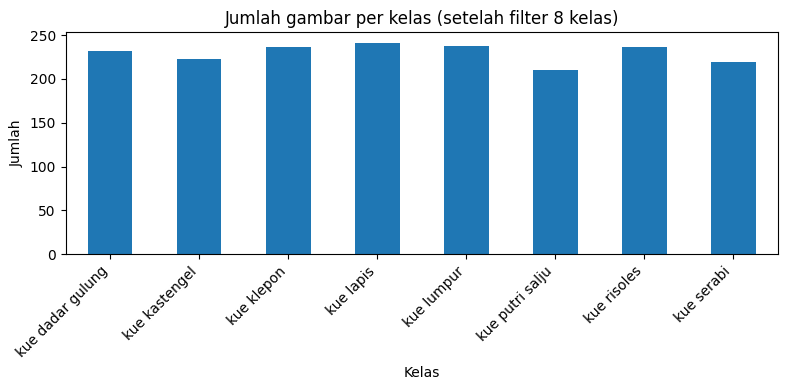

In [14]:
counts = df_all["label"].value_counts().sort_index()

plt.figure(figsize=(8,4))
counts.plot(kind="bar")
plt.title("Jumlah gambar per kelas (setelah filter 8 kelas)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

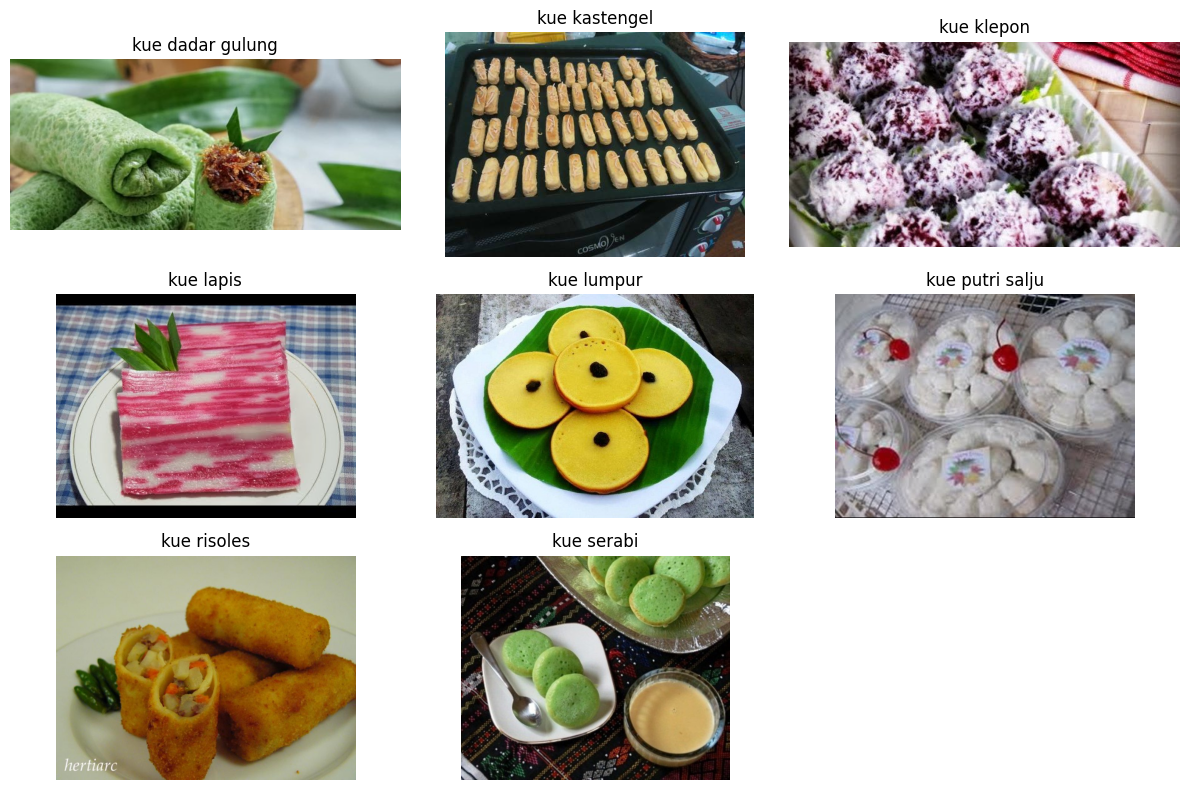

In [15]:
# contoh gambar per kelas
classes = sorted(df_all["label"].unique())
sample_rows = []
for c in classes:
    sample_rows.append(df_all[df_all["label"] == c].sample(1, random_state=RANDOM_STATE).iloc[0])

plt.figure(figsize=(12, 8))
for i, row in enumerate(sample_rows[:9]):
    img = Image.open(row["filepath"]).convert("RGB")
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(row["label"])
    plt.axis("off")
plt.tight_layout()
plt.show()

Sample size count: 300
Width range: 150 - 4592
Height range: 116 - 3448


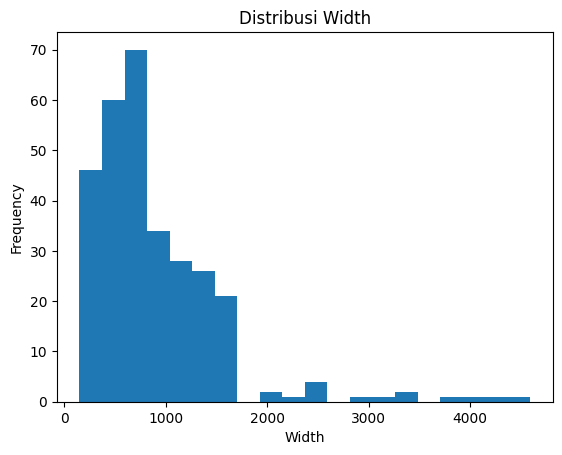

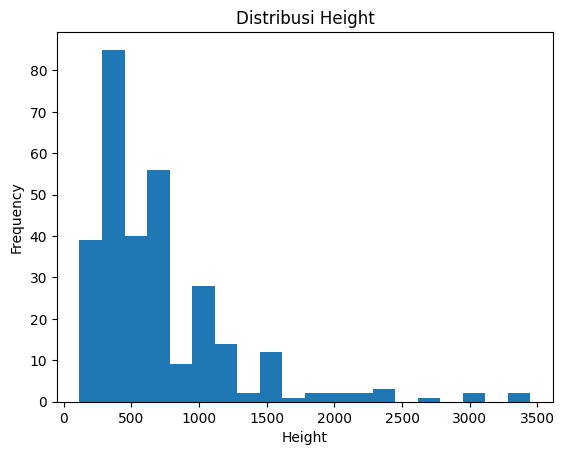

In [16]:
# cek ukuran gambar
sizes = []
sample_n = min(300, len(df_all))
for p in df_all.sample(sample_n, random_state=RANDOM_STATE)["filepath"]:
    with Image.open(p) as img:
        sizes.append(img.size)  # (W, H)

ws = [s[0] for s in sizes]
hs = [s[1] for s in sizes]

print("Sample size count:", len(sizes))
print("Width range:", min(ws), "-", max(ws))
print("Height range:", min(hs), "-", max(hs))

plt.figure()
plt.hist(ws, bins=20)
plt.title("Distribusi Width")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(hs, bins=20)
plt.title("Distribusi Height")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.show()